# multiclass classification example - SF crime dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
import databricks.koalas as ks
from pandas.testing import assert_frame_equal
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from hyperopt import hp
from hyperopt import tpe

**Gators** imports

In [4]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    ConvertColumnDatatype,
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    WOEEncoder, 
    TargetEncoder,
    OrdinalEncoder,
)
# binning
from gators.binning import (
    BinRareCategories,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    ClusterStatistics,
    PolynomialObjectFeatures,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
from gators.feature_generation_dt import (
    CyclicHourOfDay,
    CyclicDayOfMonth,
    CyclicDayOfWeek,
    CyclicMonthOfYear,
    OrdinalDayOfMonth,
    OrdinalMonthOfYear,
    OrdinalDayOfWeek,
    OrdinalHourOfDay,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
)
# feature generation
from gators.feature_generation import PlaneRotation
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
    LGBMTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

#### Pipeline composed of
* Datetime features - cyclic & ordinal
* String features
* Ordinal encoder
* Plane roration

### with pandas

In [5]:
data = pd.read_parquet('data/sf_crime.parquet')
data = data.reset_index(drop=True)
y = data['Category']
X = data.drop(['Category'], axis=1)

base_columns = list(X.columns)
classes = y.unique()
mapping = dict(zip(classes, range(len(classes))))
y = y.replace(mapping)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [6]:
X_train.head(2)

,Dates,PdDistrict,Address,X,Y
0,2015-05-13 19:26:00,CENTRAL,900 Block of BUSH ST,-122.412929,37.789687
1,2015-05-13 12:21:00,INGLESIDE,1500 Block of DOLORES ST,-122.424348,37.745046


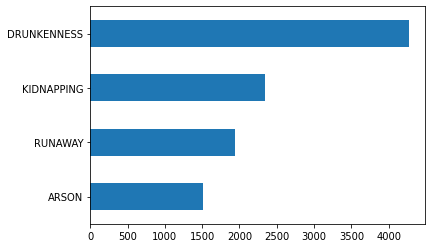

In [7]:
# target analysis
data['Category'].value_counts().iloc[::-1].plot(kind='barh');

In [8]:
model = LGBMClassifier(random_state=0, n_jobs=-1)
k = 28

offline_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    OrdinalDayOfMonth(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    CyclicDayOfMonth(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    OrdinalEncoder(),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= [15, 30, 45]),
    SelectFromModel(model=model, k=k)
]
offline_pipe = Pipeline(steps=offline_steps)
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train[base_columns], y_train)
features = list(X_train_prepro.columns)

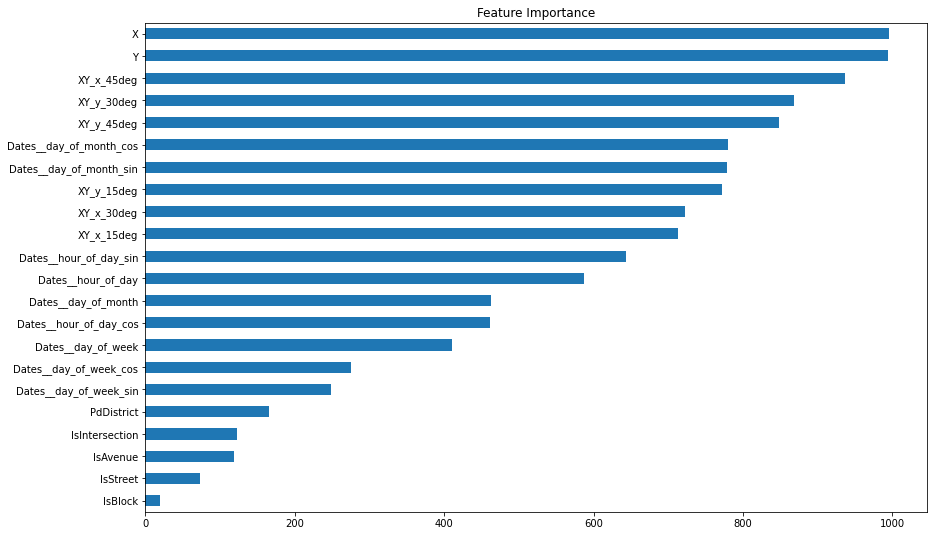

In [9]:
offline_pipe.get_feature_importances(k)[::-1].plot(
    kind='barh', 
    figsize=(14,9), 
    title='Feature Importance',
);

### with dask

In [10]:
import dask.dataframe as dd
import dask.distributed
client = dask.distributed.Client()

In [11]:
data_dd = dd.read_parquet('data/sf_crime.parquet')
y_dd = data_dd['Category']
X_dd = data_dd.drop(['Category'], axis=1)

base_columns = list(X_dd.columns)
classes = y.unique()
mapping = dict(zip(classes, range(len(classes))))
y_dd = y_dd.replace(mapping)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_dd, X_test_dd, y_train_dd, y_test_dd = \
    train_test_split.transform(X_dd, y_dd)

In [12]:
X_train_dd.compute().shape, X_test_dd.compute().shape

((7048, 5), (3020, 5))

In [13]:
X_train_dd = client.persist(X_train_dd)
X_test_dd = client.persist(X_test_dd)
y_train_dd = client.persist(y_train_dd)
y_test_dd = client.persist(y_test_dd)

offline_pipe_dd = Pipeline(steps=offline_steps)
X_train_prepro_dd = offline_pipe_dd.fit_transform(
    X_train_dd[base_columns], y_train_dd)
features_dd = list(X_train_prepro_dd.columns)

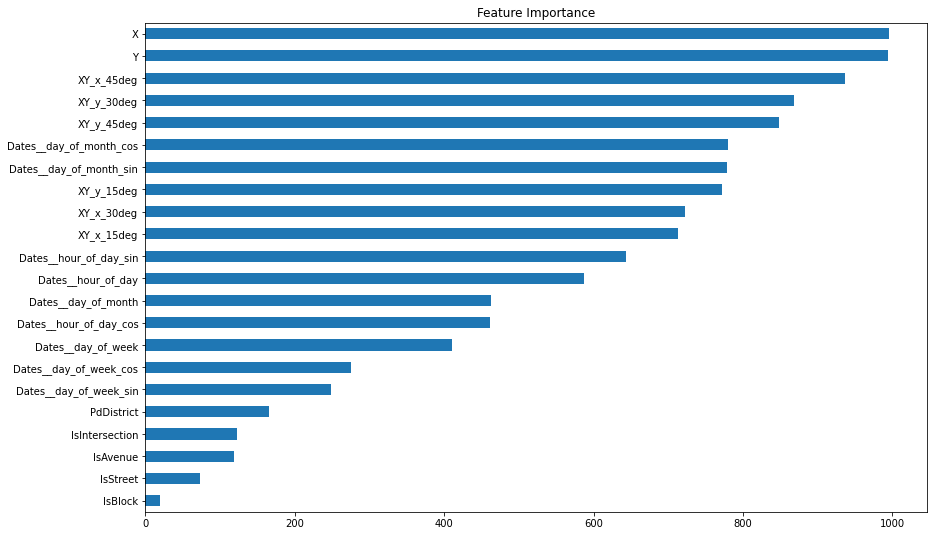

In [14]:
offline_pipe_dd.get_feature_importances(k)[::-1].plot(
    kind='barh', 
    figsize=(14,9), 
    title='Feature Importance',
);

### with koalas

In [15]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.set('spark.executor.memory', '2g')
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")
ks.set_option('compute.default_index_type', 'distributed-sequence')
from pyspark.ml.classification import RandomForestClassifier as RFCSpark

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/07 16:51:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/12/07 16:51:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [16]:
data_ks = ks.read_parquet('data/sf_crime.parquet')
y_ks = data_ks['Category']
X_ks = data_ks.drop(['Category'], axis=1)
base_columns = list(X_ks.columns)
classes = y_ks.unique().to_numpy()
mapping = dict(zip(classes, range(len(classes))))
y_ks = y_ks.replace(mapping).astype(int)

train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train_ks, X_test_ks, y_train_ks, y_test_ks = \
    train_test_split.transform(X_ks, y_ks)

In [17]:
model = RFCSpark(numTrees=20, maxDepth=4, labelCol=y_train.name, seed=0)
k = 28

offline_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    OrdinalDayOfMonth(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    CyclicDayOfMonth(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    OrdinalEncoder(),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec= [15, 30, 45]),
    SelectFromModel(model=model, k=k)
]
offline_pipe_ks = Pipeline(steps=offline_steps)

In [18]:
offline_pipe_ks = Pipeline(steps=offline_steps)
X_train_prepro_ks = offline_pipe_ks.fit_transform(X_train_ks, y_train_ks)

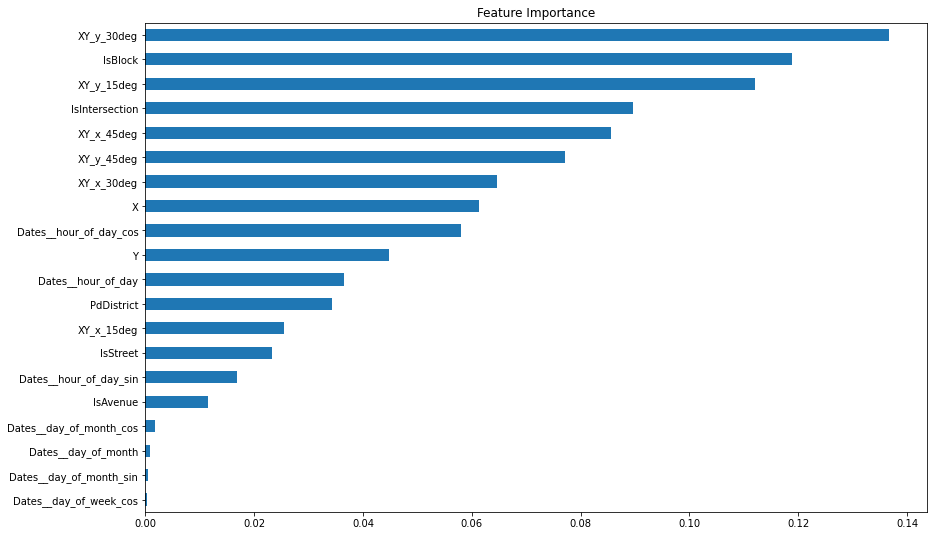

In [19]:
offline_pipe_ks.get_feature_importances(k)[::-1].plot(
    kind='barh', 
    figsize=(14,9), 
    title='Feature Importance',
);

## production pipeline

Using the features from the Pandas pipeline to compare the results between the libraries later on.  

In [20]:
prod_steps = [
    ConvertColumnDatatype(columns=['Dates'], datatype='datetime64[ns]'),
    OrdinalHourOfDay(columns=['Dates']),
    OrdinalDayOfWeek(columns=['Dates']),
    OrdinalDayOfMonth(columns=['Dates']),
    CyclicHourOfDay(columns=['Dates']),
    CyclicDayOfWeek(columns=['Dates']),
    CyclicDayOfMonth(columns=['Dates']),
    StringContains(
        columns=['Address', 'Address', 'Address', 'Address'], 
        contains_vec=['/', 'AV', 'ST', 'Block'], 
        column_names=['IsIntersection', 'IsAvenue', 'IsStreet', 'IsBlock']),
    DropColumns(columns=['Dates', 'Address']),
    OrdinalEncoder(),
    PlaneRotation(
        columns= [['X','Y']], 
        theta_vec=[15, 30, 45]),
    KeepColumns(columns_to_keep=features)
]

### with pandas

In [21]:
X_train_np = X_train[base_columns].to_numpy()
X_test_np = X_test[base_columns].to_numpy()
prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train[base_columns], y_train)
X_train_prod_prepro = prod_pipe.transform(X_train[base_columns])
X_train_prod_prepro_np = prod_pipe.transform_numpy(X_train_np)
X_test_prod_prepro = prod_pipe.transform(X_test)
X_test_prod_prepro_np = prod_pipe.transform_numpy(X_test_np)

#### check transform and transform numpy match

In [22]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_np),
    pd.DataFrame(X_train_prod_prepro.to_numpy())
)

### with dask

In [23]:
prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_dd, y_train_dd)
X_train_prod_prepro_dd = prod_pipe.transform(X_train_dd)
X_train_prod_prepro_dd_np = prod_pipe.transform_numpy(
    X_train_np)

#### check transform and transform numpy match

In [24]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_dd_np),
    pd.DataFrame(X_train_prod_prepro_dd.compute().to_numpy())
)

### with koalas

In [25]:
prod_pipe = Pipeline(steps=prod_steps)
_ = prod_pipe.fit(X_train_ks, y_ks)
X_train_prod_prepro_ks = prod_pipe.transform(X_train_ks)
X_test_prod_prepro_ks = prod_pipe.transform(X_test_ks)
X_train_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_train_np)
X_test_prod_prepro_ks_np = prod_pipe.transform_numpy(
    X_test_np)

#### check transform and transform numpy match

In [26]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_ks_np),
    pd.DataFrame(X_train_prod_prepro_ks.to_numpy())
)

#### check pandas, dask, and koalas results match - production pipeline

In [27]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro_np), 
    pd.DataFrame(X_train_prod_prepro_dd_np))

In [152]:
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_dd_np)
assert np.allclose(
    X_train_prod_prepro_np,
    X_train_prod_prepro_ks_np)

## model building

### numpy

In [29]:
features = list(X_train_prod_prepro.columns)
n_splits = 10
max_evals = 10
kfold = StratifiedKFold(n_splits=n_splits)
space = {
    'max_depth': hp.quniform('max_depth', 1, 2, 1),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
 }
model = LGBMClassifier(random_state=0, n_estimators=200, n_jobs=-1)
hyper = HyperOpt(
    model=model,
    scoring='f1_macro',
    algo=tpe.suggest,
    space=space,
    max_evals=max_evals, 
    kfold=kfold,
    features=features,
    )
y_train_np = y_train.to_numpy()
_ = hyper.fit(X_train_prod_prepro_np, y_train.to_numpy())

100%|████████| 10/10 [00:18<00:00,  1.88s/trial, best loss: -0.5374478452246978]


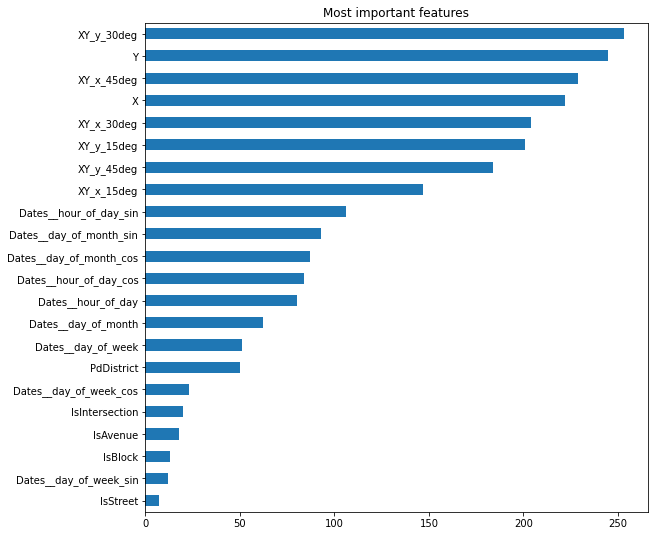

In [30]:
hyper.get_feature_importances().iloc[::-1].plot(
    kind='barh', 
    figsize=(9, 9), 
    title='Most important features',
);

In [31]:
hyper.history.sort_values('loss')

,colsample_bytree,learning_rate,max_depth,subsample,loss,status,id
4,0.564044,0.203891,2.0,0.317936,-0.537448,ok,4
1,0.717344,0.322430,2.0,0.624771,-0.536332,ok,1
8,0.221836,0.434019,2.0,0.608391,-0.535099,ok,8
7,0.347423,0.179182,2.0,0.973705,-0.533849,ok,7
6,0.588938,0.449428,2.0,0.870533,-0.532630,ok,6
9,0.946748,0.538184,2.0,0.273644,-0.528563,ok,9
2,0.679474,0.759812,2.0,0.406697,-0.523236,ok,2
0,0.356477,0.957651,2.0,0.588838,-0.517089,ok,0
5,0.428430,0.442437,1.0,0.386011,-0.504497,ok,5
3,0.353173,0.139018,1.0,0.622953,-0.483047,ok,3


In [99]:
np.logspace(-2, -1, 5)

array([0.01      , 0.01778279, 0.03162278, 0.05623413, 0.1       ])

In [210]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
param_distributions = {
    'learning_rate': np.logspace(-2, -1, 5), 
    'max_depth': [3, 4, 5],
    'subsample': [0.2, 0.3, 0.4],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'min_child_samples': [10, 20, 30]
}
from xgboost import XGBClassifier
grid = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=0, n_jobs=1, n_estimators=100),
    param_distributions=param_distributions,
    n_iter=20,
    scoring=make_scorer(f1_score, average='micro'),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
)
_ = grid.fit(X_train_prod_prepro.to_numpy(), y_train.to_numpy())
model = grid.best_estimator_
model

XGBClassifier(colsample_bytree=0.4, learning_rate=0.05623413251903491,
              max_depth=5, min_child_samples=10, objective='multi:softprob',
              subsample=0.4)

In [211]:
X_test_prod = X_test.copy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred, average="micro"):.2f}'

'f1 score: 0.62'

In [212]:
import dill
model_path = 'models/model_xgb_sfcrime.dill'
with open(model_path, 'wb') as file:
    dill.dump(model, file)

### pandas

In [213]:
assert_frame_equal(
    pd.DataFrame(X_train_prod_prepro.values),
    pd.DataFrame(prod_pipe.transform_numpy(X_train_np.copy())))
assert_frame_equal(
    pd.DataFrame(X_test_prod_prepro.values),
    pd.DataFrame(prod_pipe.transform_numpy(X_test_np.copy())))

### treelite

In [216]:
# LGBMTreeliteDumper.dump(
#     model=model,
#     toolchain='gcc',
#     parallel_comp=,
#     model_path='models/',
#     model_name='treelite_lgbm_sfcrime'
# )

In [219]:
import treelite

In [220]:
xgb_booster = XGBBoosterBuilder.train(
    model=model, 
    X_train=X_train_prod_prepro_np, 
    y_train=y_train_np,
    num_class=5
)

treelite_model = treelite.Model.from_xgboost(xgb_booster)
treelite_model.export_lib(
    toolchain='gcc', 
    libpath='./models/treelite_xgb_titanic.so', 
    params={'parallel_comp': 4},
    verbose=True
)
model_tl = treelite_runtime.Predictor(
    './models/treelite_xgb_titanic.so', verbose=False)

[18:10:56] /Users/travis/build/dmlc/treelite/src/compiler/ast_native.cc:703: Using ASTNativeCompiler
[18:10:56] /Users/travis/build/dmlc/treelite/src/compiler/ast/split.cc:29: Parallel compilation enabled; member trees will be divided into 4 translation units.
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:92: Code generation finished. Writing code to files...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file recipe.json...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu3.c...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu2.c...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu1.c...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file tu0.c...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Writing file header.h...
[18:10:56] /Users/travis/build/dmlc/treelite/src/c_api/c_api.cc:97: Wri

In [221]:
import treelite_runtime
model_tl = treelite_runtime.Predictor(
    './models/treelite_lgbm_sfcrime.so', verbose=False)

#### check the models prediction match

In [204]:
# model_pd = LGBMClassifier(random_state=0, n_estimators=200, n_jobs=-1)
# model = LGBMClassifier(random_state=0, n_estimators=200, n_jobs=-1)
# model.fit(prod_pipe.transform(X_train), y_train)
# model_pd.fit(prod_pipe.transform_numpy(X_train_np), y_train)

In [205]:
# X1 = prod_pipe.transform(X_train)
# X1_np = prod_pipe.transform_numpy(X_train_np)
# assert_frame_equal(
#     pd.DataFrame(X1.values),
#     pd.DataFrame(X1_np)
# )
# assert np.allclose(X1.values, X1_np)

In [228]:
!pip freeze | grep treelite

treelite==2.1.0
treelite-runtime==2.1.0


/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1113, in f1_score
    return fbeta_score(
  File "/Users/cpoli/gators38/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1251, in fbeta_score
    _, _, 

In [224]:
# y_pred_pd = model.predict(
#     prod_pipe.transform(X_train))
y_pred_np = model.predict(
    prod_pipe.transform_numpy(X_train_np.copy()))
y_pred_tl = model_tl.predict(
    treelite_runtime.DMatrix(
        prod_pipe.transform_numpy(
            X_train_np.copy()
        )
    )
)
# assert np.allclose(y_pred_np, y_pred_pd)
assert np.allclose(y_pred_np, np.argmax(y_pred_tl, axis=1))

AssertionError: 

## model evaluation

In [ ]:
model_np = copy.copy(hyper.model)
X_test_prod = X_test.copy()
X_test_prod_prepro_np = prod_pipe.transform(X_test_prod).to_numpy()
y_test_pred = model_np.predict(X_test_prod_prepro_np)
f'f1 score: {f1_score(y_test, y_test_pred, average="micro"):.2f}'

## per-sample bechmarking

### pipeline only

In [ ]:
x = X_train_prod.iloc[[0]]
xnp = x.to_numpy()
stats_pd = %timeit -o prod_pipe.transform(x)
stats_np = %timeit -o prod_pipe.transform_numpy(xnp.copy())

In [ ]:
speedup = 1e3 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

### pipeline & model

In [ ]:
stats_pd = %timeit -o model_pd.predict(prod_pipe.transform(x))[0]
stats_np = %timeit -o model.predict(prod_pipe.transform_numpy(xnp.copy()))[0]
stats_tl = %timeit -o model_tl.predict(treelite_runtime.DMatrix(prod_pipe.transform_numpy(xnp.copy())))

In [ ]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_np).split(' ')[0])
f'Speed-up Pandas VS Numpy x{round(speedup)}'

In [ ]:
speedup = 1000 * float(str(stats_pd).split(' ')[0]) / float(str(stats_tl).split(' ')[0])
f'Speed-up Pandas VS Numpy&Treelite x{round(speedup)}'